# Multi-Class Image Classification Deep Learning Model for Intel Image Classification Using TensorFlow Take 3
### David Lowe
### January 11, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Intel Image Classification dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset contains over 17,000 images of size 150x150 distributed under six categories: buildings, forest, glacier, mountain, sea, and street. There are approximately 14,000 images in the training set and 3,000 in the test/validation set. This dataset was initially published on https://datahack.analyticsvidhya.com by Intel as part of a data science competition.

From iteration Take1, we constructed a simple three-layer CNN neural network as the baseline model. We plan to use this model's performance as the baseline measurement for future iterations of modeling.

From iteration Take2, we constructed a VGG16 neural network as an alternate model. We also compared this model's performance with the baseline model from iteration Take1.

In this Take3 iteration, we will construct an InceptionV3 neural network as an alternate model. We will compare this model's performance with the baseline model from iteration Take1.

ANALYSIS: From iteration Take1, the baseline model’s performance achieved an accuracy score of 88.62% after 30 epochs using the training images. The baseline model also processed the validation images with an accuracy score of 85.37%.

From iteration Take2, the VGG16 model’s performance achieved an accuracy score of 83.57% after 30 epochs using the training images. The VGG16 model also processed the validation images with an accuracy score of 79.53%.

In this Take3 iteration, the InceptionV3 model’s performance achieved an accuracy score of 91.24% after 30 epochs using the training images. The InceptionV3 model also processed the validation images with an accuracy score of 87.10%.

CONCLUSION: In this iteration, the TensorFlow CNN models appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Intel Image Classification Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://www.kaggle.com/puneet6060/intel-image-classification

One potential source of performance benchmarks: https://www.kaggle.com/puneet6060/intel-image-classification

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the optional packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jan  7 18:36:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.25

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
# DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.01)
DEFAULT_INITIALIZER = tf.keras.initializers.GlorotUniform(seed=seedNum)
EPOCH_NUMBER = 30
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = (150, 150, 3)
NUM_CLASSES = 6

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.0


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm archive.zip

rm: cannot remove 'archive.zip': No such file or directory


In [15]:
!wget https://dainesanalytics.com/datasets/kaggle-intel-image-classification/archive.zip

--2021-01-07 18:36:05--  https://dainesanalytics.com/datasets/kaggle-intel-image-classification/archive.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 143.204.93.68, 143.204.93.43, 143.204.93.70, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|143.204.93.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363177800 (346M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 346.35M  45.5MB/s    in 8.4s    

2021-01-07 18:36:14 (41.2 MB/s) - ‘archive.zip’ saved [363177800/363177800]



In [16]:
staging_dir = 'staging/'
!mkdir staging/

In [17]:
# Unzip and put the files into the staging folder
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
zip_ref.close()

In [18]:
training_dir = 'staging/seg_train/'
validation_dir = 'staging/seg_test/'
class1_name = 'buildings'
class2_name = 'forest'
class3_name = 'glacier'
class4_name = 'mountain'
class5_name = 'sea'
class6_name = 'street'

In [19]:
# Brief listing of training image files for class 1
training_class1_dir = os.path.join(training_dir, class1_name)
training_class1_files = os.listdir(training_class1_dir)
print('Number of training images for', class1_name, ':', len(os.listdir(training_class1_dir)))
print('Training samples for', class1_name, ':', training_class1_files[:10])

# Brief listing of training image files for class 2
training_class2_dir = os.path.join(training_dir, class2_name)
training_class2_files = os.listdir(training_class2_dir)
print('Number of training images for', class2_name, ':', len(os.listdir(training_class2_dir)))
print('Training samples for', class2_name, ':', training_class2_files[:10])

# Brief listing of training image files for class 3
training_class3_dir = os.path.join(training_dir, class3_name)
training_class3_files = os.listdir(training_class3_dir)
print('Number of training images for', class3_name, ':', len(os.listdir(training_class3_dir)))
print('Training samples for', class3_name, ':', training_class3_files[:10])

# Brief listing of training image files for class 4
training_class4_dir = os.path.join(training_dir, class4_name)
training_class4_files = os.listdir(training_class4_dir)
print('Number of training images for', class4_name, ':', len(os.listdir(training_class4_dir)))
print('Training samples for', class4_name, ':', training_class4_files[:10])

# Brief listing of training image files for class 5
training_class5_dir = os.path.join(training_dir, class5_name)
training_class5_files = os.listdir(training_class5_dir)
print('Number of training images for', class5_name, ':', len(os.listdir(training_class5_dir)))
print('Training samples for', class5_name, ':', training_class5_files[:10])

# Brief listing of training image files for class 6
training_class6_dir = os.path.join(training_dir, class6_name)
training_class6_files = os.listdir(training_class6_dir)
print('Number of training images for', class6_name, ':', len(os.listdir(training_class6_dir)))
print('Training samples for', class6_name, ':', training_class6_files[:10])

Number of training images for buildings : 2191
Training samples for buildings : ['9807.jpg', '12736.jpg', '16377.jpg', '19466.jpg', '14124.jpg', '11307.jpg', '15304.jpg', '6970.jpg', '17951.jpg', '17552.jpg']
Number of training images for forest : 2271
Training samples for forest : ['17923.jpg', '12499.jpg', '8962.jpg', '18674.jpg', '12993.jpg', '16032.jpg', '10937.jpg', '842.jpg', '5814.jpg', '15841.jpg']
Number of training images for glacier : 2404
Training samples for glacier : ['10003.jpg', '10372.jpg', '19844.jpg', '18014.jpg', '14216.jpg', '128.jpg', '10793.jpg', '13003.jpg', '791.jpg', '11176.jpg']
Number of training images for mountain : 2512
Training samples for mountain : ['17049.jpg', '14844.jpg', '19266.jpg', '5065.jpg', '12439.jpg', '6032.jpg', '2293.jpg', '480.jpg', '19756.jpg', '5514.jpg']
Number of training images for sea : 2274
Training samples for sea : ['10740.jpg', '1450.jpg', '3307.jpg', '1892.jpg', '14407.jpg', '15086.jpg', '4450.jpg', '13375.jpg', '2944.jpg', '77

In [20]:
# Brief listing of validation image files for class 1
validation_class1_dir = os.path.join(validation_dir, class1_name)
validation_class1_files = os.listdir(validation_class1_dir)
print('Number of validation images for', class1_name, ':', len(os.listdir(validation_class1_dir)))
print('Validation samples for', class1_name, ':', validation_class1_files[:10])

# Brief listing of validation image files for class 2
validation_class2_dir = os.path.join(validation_dir, class2_name)
validation_class2_files = os.listdir(validation_class2_dir)
print('Number of validation images for', class2_name, ':', len(os.listdir(validation_class2_dir)))
print('Validation samples for', class2_name, ':', validation_class2_files[:10])

# Brief listing of validation image files for class 3
validation_class3_dir = os.path.join(validation_dir, class3_name)
validation_class3_files = os.listdir(validation_class3_dir)
print('Number of validation images for', class3_name, ':', len(os.listdir(validation_class3_dir)))
print('Validation samples for', class3_name, ':', validation_class3_files[:10])

# Brief listing of validation image files for class 4
validation_class4_dir = os.path.join(validation_dir, class4_name)
validation_class4_files = os.listdir(validation_class4_dir)
print('Number of validation images for', class4_name, ':', len(os.listdir(validation_class4_dir)))
print('Validation samples for', class4_name, ':', validation_class4_files[:10])

# Brief listing of validation image files for class 5
validation_class5_dir = os.path.join(validation_dir, class5_name)
validation_class5_files = os.listdir(validation_class5_dir)
print('Number of validation images for', class5_name, ':', len(os.listdir(validation_class5_dir)))
print('Validation samples for', class5_name, ':', validation_class5_files[:10])

# Brief listing of validation image files for class 6
validation_class6_dir = os.path.join(validation_dir, class6_name)
validation_class6_files = os.listdir(validation_class6_dir)
print('Number of validation images for', class6_name, ':', len(os.listdir(validation_class6_dir)))
print('Validation samples for', class6_name, ':', validation_class6_files[:10])

Number of validation images for buildings : 437
Validation samples for buildings : ['20752.jpg', '23097.jpg', '20465.jpg', '23757.jpg', '20606.jpg', '24160.jpg', '21793.jpg', '22421.jpg', '21309.jpg', '20989.jpg']
Number of validation images for forest : 474
Validation samples for forest : ['23161.jpg', '23308.jpg', '23852.jpg', '21179.jpg', '20306.jpg', '21919.jpg', '20978.jpg', '23743.jpg', '20510.jpg', '24234.jpg']
Number of validation images for glacier : 553
Validation samples for glacier : ['24323.jpg', '22212.jpg', '23260.jpg', '21409.jpg', '23703.jpg', '21437.jpg', '20187.jpg', '21816.jpg', '23154.jpg', '23883.jpg']
Number of validation images for mountain : 525
Validation samples for mountain : ['22020.jpg', '20866.jpg', '20497.jpg', '22503.jpg', '22040.jpg', '20327.jpg', '21055.jpg', '20435.jpg', '23975.jpg', '20545.jpg']
Number of validation images for sea : 510
Validation samples for sea : ['20640.jpg', '22433.jpg', '23974.jpg', '24136.jpg', '24099.jpg', '23901.jpg', '24073

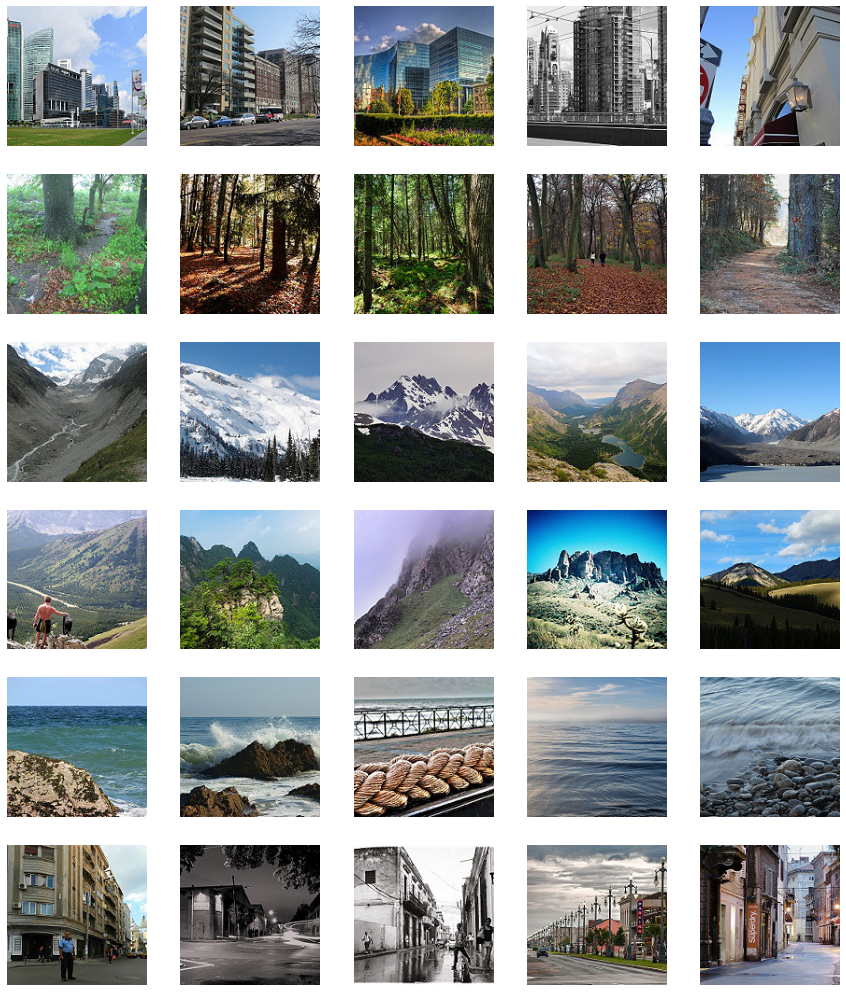

In [21]:
# Plot some training images from the dataset
nrows = 6
ncols = 5

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

reset_random(seedNum)
number_elements = ncols
random_training_class1 = random.sample(training_class1_files, number_elements)
random_training_class2 = random.sample(training_class2_files, number_elements)
random_training_class3 = random.sample(training_class3_files, number_elements)
random_training_class4 = random.sample(training_class4_files, number_elements)
random_training_class5 = random.sample(training_class5_files, number_elements)
random_training_class6 = random.sample(training_class6_files, number_elements)
next_class1 = [os.path.join(training_class1_dir, fname) for fname in random_training_class1]
next_class2 = [os.path.join(training_class2_dir, fname) for fname in random_training_class2]
next_class3 = [os.path.join(training_class3_dir, fname) for fname in random_training_class3]
next_class4 = [os.path.join(training_class4_dir, fname) for fname in random_training_class4]
next_class5 = [os.path.join(training_class5_dir, fname) for fname in random_training_class5]
next_class6 = [os.path.join(training_class6_dir, fname) for fname in random_training_class6]

for i, img_path in enumerate(next_class1 + next_class2 + next_class3 + next_class4 + next_class5 + next_class6):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [22]:
print('Loading and pre-processing the training images...')
reset_random(seedNum)
# training_datagen = ImageDataGenerator(rescale=1/255)
training_datagen = ImageDataGenerator(rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    fill_mode='nearest')
training_generator = training_datagen.flow_from_directory(training_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
print('Number of image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the training images...
Found 14034 images belonging to 6 classes.
Number of image batches per epoch of modeling: 439


In [23]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the validation images...
Found 3000 images belonging to 6 classes.
Number of image batches per epoch of modeling: 94


In [24]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [25]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [26]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [28]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=IMAGE_SHAPE, output_param=NUM_CLASSES, opt_param=DEFAULT_OPTIMIZER, loss_param=DEFAULT_LOSS, metrics_param=DEFAULT_METRICS):
    nn_model = keras.applications.InceptionV3(include_top=True, weights=None, input_shape=input_param, classes=output_param)
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [29]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCH_NUMBER,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/30
439/439 [==============================] - 97s 203ms/step - loss: 1.4480 - accuracy: 0.4133 - val_loss: 1.1099 - val_accuracy: 0.5957
Epoch 2/30
439/439 [==============================] - 86s 196ms/step - loss: 0.9899 - accuracy: 0.6121 - val_loss: 0.8666 - val_accuracy: 0.6867
Epoch 3/30
439/439 [==============================] - 86s 196ms/step - loss: 0.8127 - accuracy: 0.6930 - val_loss: 0.8280 - val_accuracy: 0.7043
Epoch 4/30
439/439 [==============================] - 86s 196ms/step - loss: 0.7078 - accuracy: 0.7369 - val_loss: 0.9057 - val_accuracy: 0.6537
Epoch 5/30
439/439 [==============================] - 86s 196ms/step - loss: 0.6304 - accuracy: 0.7708 - val_loss: 0.5730 - val_accuracy: 0.7847
Epoch 6/30
439/439 [==============================] - 86s 195ms/step - loss: 0.5946 - accuracy: 0.7807 - val_loss: 0.9212 - val_accuracy: 0.6993
Epoch 7/30
439/439 [==============================] - 86s 195ms/step - loss: 0.5360 - accuracy: 0.8034 - val_loss: 0.4687 - val_ac

In [30]:
nn_model_0.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

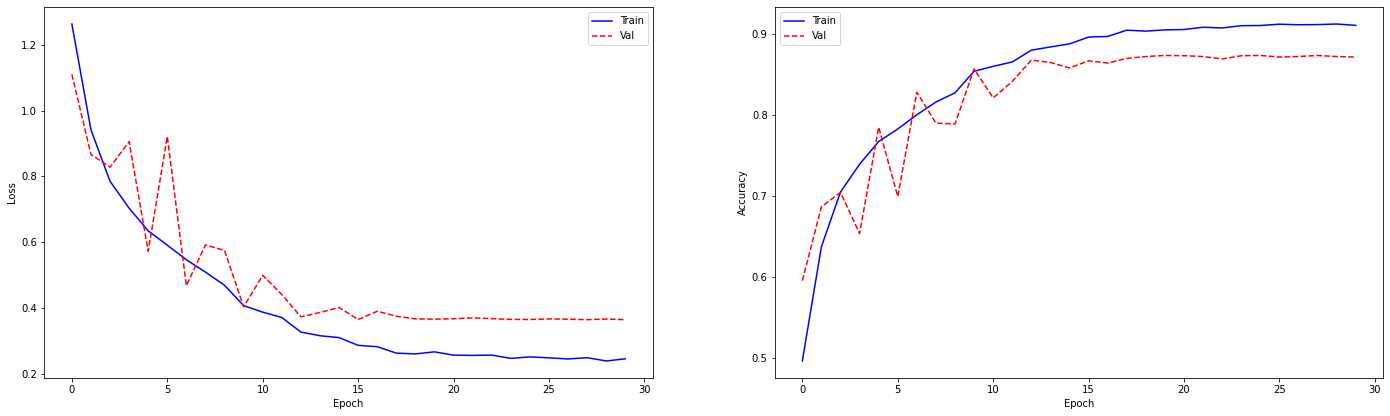

In [31]:
plot_metrics(nn_model_history)

In [32]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [33]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [34]:
# Not applicable for this iteration of modeling

In [35]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [36]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [37]:
final_model = nn_model_0

# Display a summary of the final model
final_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [38]:
# Print the labels used for the modeling
print(validation_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [39]:
final_model.evaluate(validation_generator, verbose=1)

94/94 [==============================] - 4s 38ms/step - loss: 0.3656 - accuracy: 0.8710


[0.3655509054660797, 0.8709999918937683]

In [40]:
test_pred = final_model.predict(validation_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = validation_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.871
[[381   4   2   5   5  40]
 [  1 467   1   3   1   1]
 [  4   5 427  83  27   7]
 [  1   6  51 444  21   2]
 [ 14   3  23  13 454   3]
 [ 41   8   0   3   9 440]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       437
           1       0.95      0.99      0.97       474
           2       0.85      0.77      0.81       553
           3       0.81      0.85      0.83       525
           4       0.88      0.89      0.88       510
           5       0.89      0.88      0.89       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [41]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [42]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:43:28.116685
